## Mobile Games A/B Testing with Cookie Cats
<p><a href="https://www.facebook.com/cookiecatsgame">Cookie Cats</a> is a hugely popular mobile puzzle game developed by <a href="http://tactile.dk">Tactile Entertainment</a>. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level.
<p>As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.</p>
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cc_gates.png" alt=""></p>
<p>Initially the first gate was placed at level 30. This project is going to analyze an AB-test where the first gate in Cookie Cats was moved from level 30 to level 40.</p>

In [1]:
import pandas as pd

df = pd.read_csv('datasets/cookie_cats.csv')

print(df.head())
print('\n')
print('Rows of dataframe : ' + str(len(df)) + ', with ' + str(len(df.userid.unique())) + ' different players')

   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True


Rows of dataframe : 90189, with 90189 different players


<p>The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:</p>
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the group with the moved gate (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first 14 days after install.</li>
<li><code>retention_1</code> - did the player come back and play <strong>1 day</strong> after installing?</li>
<li><code>retention_7</code> - did the player come back and play <strong>7 days</strong> after installing?</li>
</ul>
<p>When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>.

In [30]:
print('Number of players in each AB groups :')
ab_group = df[['version', 'userid']].groupby('version', as_index=False).userid.count()
ab_group.columns = ['version', 'number of players']
print(ab_group)

Number of players in each AB groups :
   version  number of players
0  gate_30              44700
1  gate_40              45489


[]


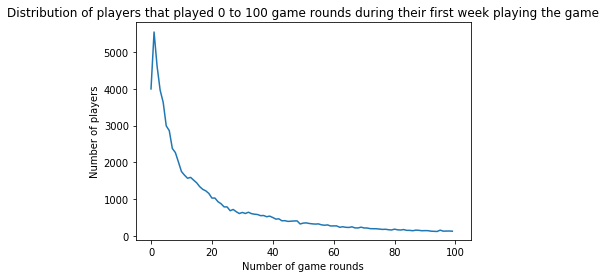

In [17]:
import matplotlib.pyplot as plt
 
plot_df = df.groupby('sum_gamerounds').userid.count()

ax = plot_df.head(100).plot()
ax.set_xlabel("Number of game rounds")
ax.set_ylabel("Number of players")
plt.axis([-5, 105, -100, 5800])
plt.title('Distribution of players that played 0 to 100 game rounds during their first week playing the game')
print(plt.plot())

#### 1-day retention analysis
<p>In the plot above we can see that some players install the game but then never play it (0 game rounds), some players just play a couple of game rounds in their first week, and some get really hooked!</p>
<p>What we want is for players to like the game and to get hooked. A common metric in the video gaming industry for how fun and engaging a game is <em>1-day retention</em>: The percentage of players that comes back and plays the game <em>one day</em> after they have installed it.  The higher 1-day retention is, the easier it is to retain players and build a large player base. </p>

In [4]:
retention_1day = round((df.retention_1.mean() * 100), 2)
print('Percentage of players that came back the day after they installed :', retention_1day, '%')

Percentage of players that came back the day after they installed : 44.52 %


In [29]:
ab_retention1 = df[['version', 'retention_1']].groupby('version', as_index=False).retention_1.mean()
ab_retention1.retention_1 = round((ab_retention1.retention_1 * 100), 2)
ab_retention1.columns = ['version', 'percentage of players']
print('1-day retention for each AB groups :')
print(ab_retention1)

1-day retention for each AB groups :
   version  percentage of players
0  gate_30                  44.82
1  gate_40                  44.23


<p>It appears that there was a slight decrease in 1-day retention when the gate was moved to level 40 (44.23%) compared to the control when it was at level 30 (44.82%). It's a small change, but even small changes in retention can have a large impact.</p>
<p>Now we will use bootstrapping to get the certainty of these retention numbers: We will repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.</p>

[]


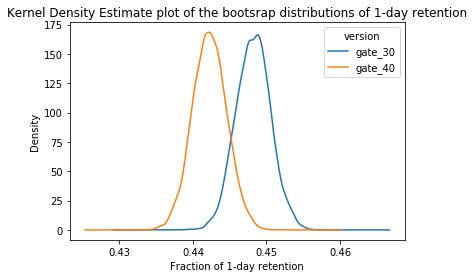

In [18]:

boot_1d = []
for i in range(10000):
    boot_mean = df.sample(frac=1, replace=True).groupby('version').retention_1.mean()
    boot_1d.append(boot_mean)
    
boot_1d = pd.DataFrame(boot_1d)

boot_1d.plot.kde()
plt.xlabel('Fraction of 1-day retention')
plt.title('Kernel Density Estimate plot of the bootsrap distributions of 1-day retention')
print(plt.plot())

<p>These two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups. Just eyeballing this plot, we can see that there seems to be some evidence of a difference, albeit small. Let's zoom in on the difference in 1-day retention.</p>

[]
The probability that the difference is above 0% = 0.9643


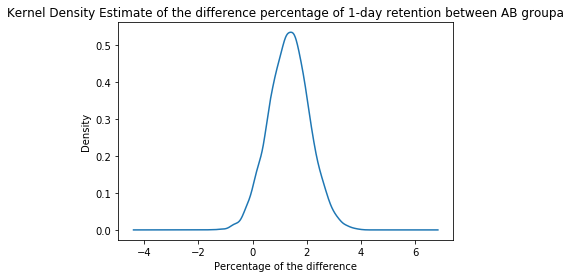

In [31]:
boot_1d['diff'] = (boot_1d.gate_30 - boot_1d.gate_40)/boot_1d.gate_40 * 100

ax = boot_1d['diff'].plot.kde()
plt.title('Kernel Density Estimate of the difference percentage of 1-day retention between AB groupa')
ax.set_xlabel('Percentage of the difference')
print(plt.plot())
prob = (boot_1d['diff']>0).sum() / len(boot_1d['diff'])

print('The probability that the difference is above 0% =', prob)

<p>From this chart, we can see that the most likely % difference is around 1% - 2%, and that most of the distribution is above 0%, in favor of a gate at level 30. From calculation, we get that the probability that the difference is above 0% is 0.9643.</p>

#### 7-day retention analysis
<p>The bootstrap analysis tells us that there is a high probability that 1-day retention is better when the gate is at level 30. However, since players have only been playing the game for one day, it is likely that most players haven't reached level 30 yet. That is, many players won't have been affected by the gate, even if it's as early as level 30. </p>
<p>But after having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention. That is: What percentage of the people that installed the game also showed up a week later to play the game again.</p>

In [32]:
ab_retention7 = df[['version', 'retention_7']].groupby('version', as_index=False).retention_7.mean()
ab_retention7.retention_7 = round((ab_retention7.retention_7 * 100), 2)
ab_retention7.columns = ['version', 'percentage of players']
print('7-day retention for each AB groups :')
print(ab_retention7)

7-day retention for each AB groups :
   version  percentage of players
0  gate_30                  19.02
1  gate_40                  18.20


<p>Like with 1-day retention, we see that 7-day retention is slightly lower (18.20%) when the gate is at level 40 than when the gate is at level 30 (19.02%). This difference is also larger than for 1-day retention, presumably because more players have had time to hit the first gate. We also see that the <em>overall</em> 7-day retention is lower than the <em>overall</em> 1-day retention; fewer people play a game a week after installing than a day after installing.</p>
<p>But as before, let's use bootstrap analysis to figure out how certain we should be of the difference between the AB-groups.</p>

[]
The probability that the difference is above 0% = 0.9996


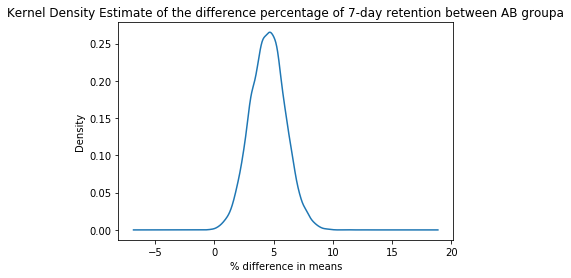

In [57]:
boot_7d = []
for i in range(10000):
    boot_mean = df.sample(frac=1, replace=True).groupby('version').retention_7.mean()
    boot_7d.append(boot_mean)
    
boot_7d = pd.DataFrame(boot_7d)

boot_7d['diff'] = (boot_7d.gate_30 - boot_7d.gate_40)/boot_7d.gate_40 * 100

boot_7d['diff'].plot.kde()
plt.xlabel("% difference in means")
plt.title('Kernel Density Estimate of the difference percentage of 7-day retention between AB groupa')

print(plt.plot())

prob = (boot_7d['diff'] > 0).sum() *1.0 /len(boot_7d['diff'])

print('The probability that the difference is above 0% =', prob)

### The conclusion
<p>The bootstrap result tells us that there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40. The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — we should <strong>not</strong> move the gate from level 30 to level 40. There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention <em>is</em> one of the most important metrics. If we don't retain our player base, it doesn't matter how much money they spend in-game.</p>
<p>So, why is retention higher when the gate is positioned earlier? One could expect the opposite: The later the obstacle, the longer people are going to engage with the game. But this is not what the data tells us. The theory of <em>hedonic adaptation</em> can give one explanation for this. In short, hedonic adaptation is the tendency for people to get less and less enjoyment out of a fun activity over time if that activity is undertaken continuously. By forcing players to take a break when they reach a gate, their enjoyment of the game is prolonged. But when the gate is moved to level 40, fewer players make it far enough, and they are more likely to quit the game because they simply got bored of it. </p>